In [3]:
# 1. Các thư viện cần thiết
!pip3 install -U git+https://github.com/PYFTS/pyFTS
import pandas as pd
import numpy as np
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.models import chen
from pyFTS.common import FLR
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Fix the import in the pyFTS library if necessary
# In the file '/usr/local/lib/python3.10/dist-packages/pyFTS/common/transformations/trend.py', change:
# from pandas import datetime
# to:
# from pandas import Timestamp

  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-f_kkgcla
  Running command git clone --filter=blob:none --quiet https://github.com/PYFTS/pyFTS /tmp/pip-req-build-f_kkgcla
  Resolved https://github.com/PYFTS/pyFTS to commit 4e0ee7cdd9fc9a8ac9170c0c3496536ef0378cb7
  Preparing metadata (setup.py) ... done


# **Chia train test validate theo tỉ lệ 8:1:1**

In [4]:
# 2. Đọc file csv và lấy  giá Close
df = pd.read_csv('BTC.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df1 = df['Close'].values

In [5]:
# 3. Chia train test validate theo tỉ lệ 8:1:1
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

/usr/local/lib/python3.10/dist-packages/pyFTS/partitioners/partitioner.py:278: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


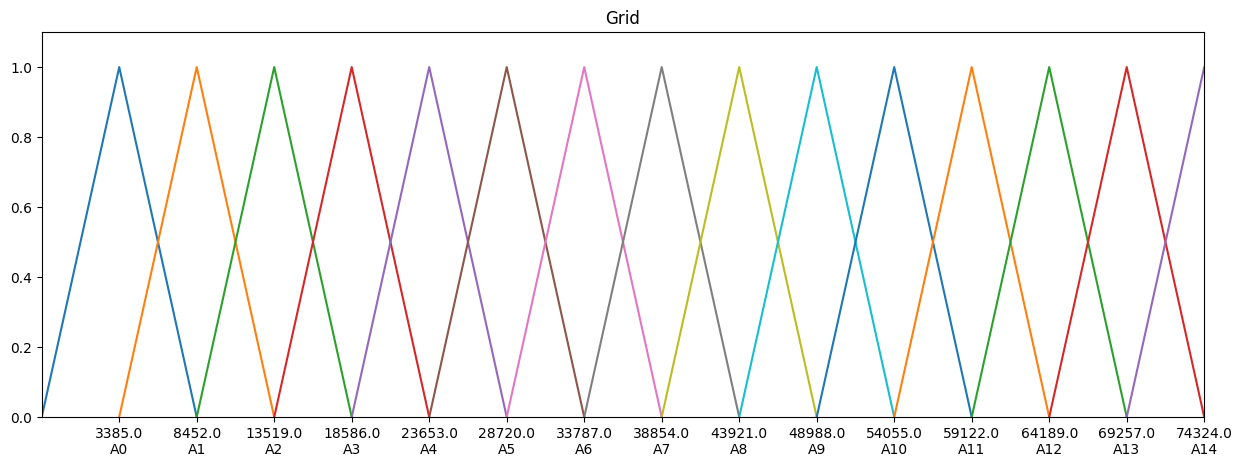

In [6]:
# 4. Xây dựng phân vùng mờ (Grid Partitioner)
partitioner = Grid.GridPartitioner(data=train_data, npart=15)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
partitioner.plot(ax)

In [7]:
# 5. Fuzzyfy dữ liệu huấn luyện (Chuyển đổi dữ liệu huấn luyện thành các giá trị mờ)
fuzzyfied = partitioner.fuzzyfy(train_data)

In [8]:
# 6. Tạo các mối quan hệ logic giữa các  mờ (FLR)
patterns = FLR.generate_non_recurrent_flrs(fuzzyfied)
print([str(k) for k in patterns])

['A0 -> A0', 'A0 -> A1', 'A1 -> A0', 'A1 -> A1', 'A0 -> A2', 'A1 -> A2', 'A2 -> A1', 'A2 -> A2', 'A2 -> A0', 'A1 -> A3', 'A2 -> A3', 'A3 -> A1', 'A3 -> A2', 'A3 -> A3', 'A2 -> A4', 'A3 -> A4', 'A4 -> A3', 'A4 -> A4', 'A4 -> A2', 'A3 -> A5', 'A4 -> A5', 'A5 -> A3', 'A5 -> A4', 'A5 -> A5', 'A4 -> A6', 'A5 -> A6', 'A6 -> A5', 'A6 -> A6', 'A5 -> A7', 'A6 -> A7', 'A7 -> A6', 'A7 -> A7', 'A6 -> A8', 'A7 -> A8', 'A8 -> A7', 'A8 -> A8', 'A8 -> A6', 'A7 -> A5', 'A7 -> A9', 'A8 -> A9', 'A9 -> A8', 'A9 -> A9', 'A8 -> A10', 'A9 -> A10', 'A10 -> A9', 'A10 -> A10', 'A9 -> A11', 'A10 -> A11', 'A11 -> A10', 'A11 -> A11', 'A10 -> A8', 'A11 -> A8', 'A11 -> A9', 'A10 -> A12', 'A11 -> A12', 'A12 -> A11', 'A12 -> A12', 'A12 -> A10', 'A9 -> A7', 'A11 -> A13', 'A12 -> A13', 'A13 -> A12', 'A13 -> A13', 'A13 -> A11', 'A6 -> A4']


In [9]:
# 7. Xây dựng mô hình FTS
model = chen.ConventionalFTS(partitioner=partitioner)
model.fit(train_data)
print(model)

Conventional FTS:
A0 -> A0,A1
A1 -> A0,A1,A2
A2 -> A1,A2,A3
A3 -> A2,A3,A4
A4 -> A3,A4,A5
A5 -> A4,A5,A6
A6 -> A5,A6,A7
A7 -> A6,A7,A8
A8 -> A7,A8,A9
A9 -> A10,A8,A9
A10 -> A10,A11,A9
A11 -> A10,A11,A12,A9
A12 -> A11,A12,A13
A13 -> A12,A13



In [10]:
# 8. Dự đoán dữ liệu test, val
y_pred_test = model.predict(test_data)
y_pred_val = model.predict(val_data)

In [11]:
# 10. Đánh giá độ chính xác thuật toán
test_mae = mean_absolute_error(y_pred_test, test_data)
test_mape = mean_absolute_percentage_error(y_pred_test, test_data)
test_rmse = np.sqrt(mean_squared_error(y_pred_test, test_data))
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

val_mae = mean_absolute_error(y_pred_val, val_data)
val_rmse = np.sqrt(mean_squared_error(y_pred_val, val_data))
val_mape = mean_absolute_percentage_error(y_pred_val, val_data)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Validation MAPE:', val_mape)

Testing MAE: 1471.6500927539462
Testing RMSE: 1630.1972063627352
Testing MAPE: 0.053231024530357815
Validation MAE: 1601.3849239671467
Validation RMSE: 1958.9959926184406
Validation MAPE: 0.03104685900377956


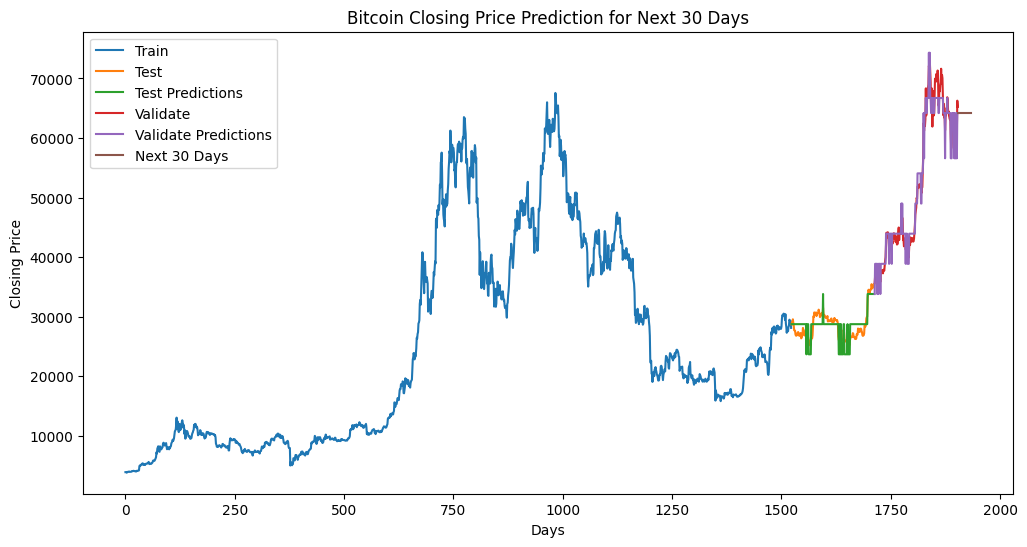

Predicted closing prices for the next 30 days:
[64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963]


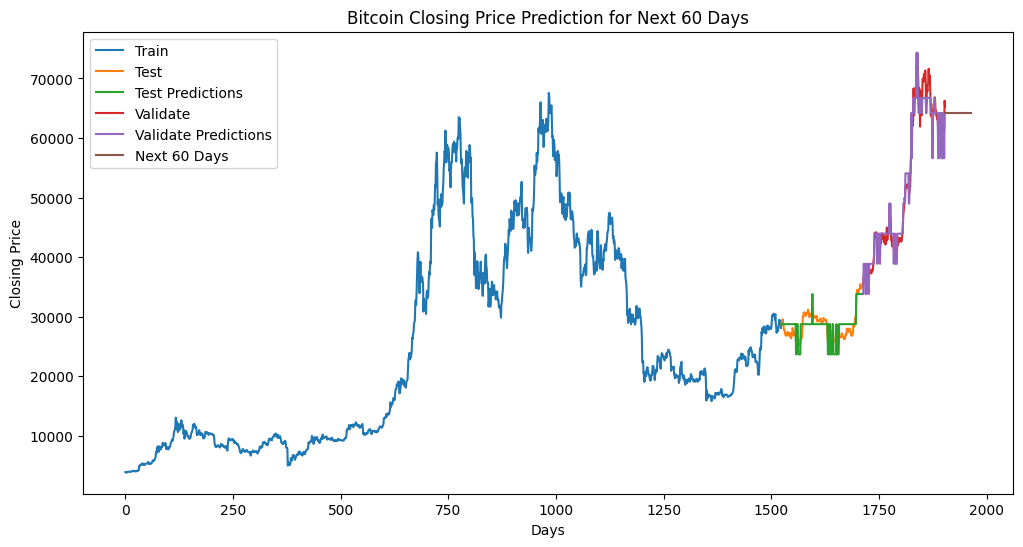

Predicted closing prices for the next 60 days:
[64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963]


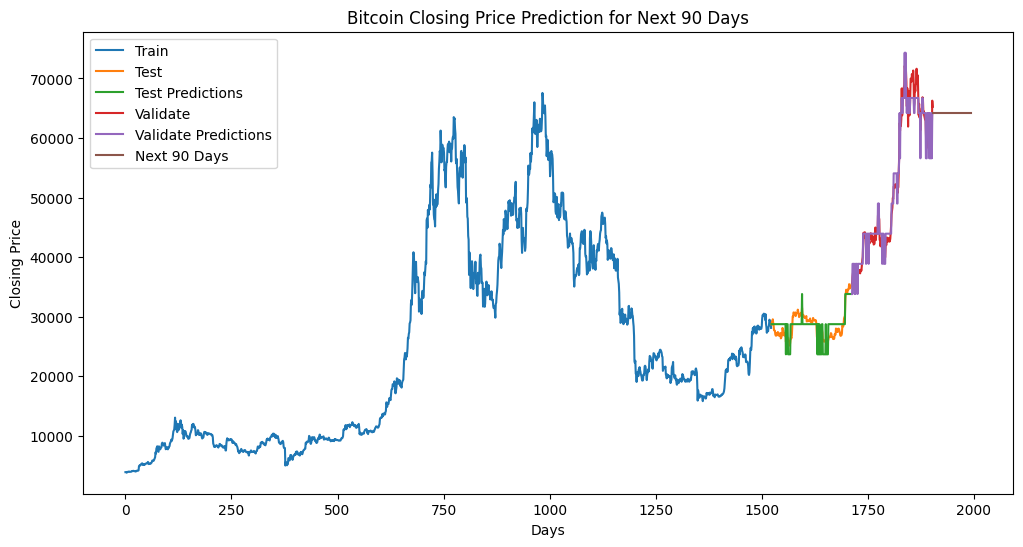

Predicted closing prices for the next 90 days:
[64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 6

In [12]:
# 10. Dự đoán 30, 60, 90 ngày tiếp theo
time_step = 100
def predict_future(model, data, days):
    temp_input = list(data)
    lst_output = []

    for _ in range(days):
        x_input = temp_input[-1]  # Lấy giá trị cuối cùng để dự đoán tiếp
        yhat = model.predict([x_input])[0]  # Dự đoán giá trị tiếp theo
        temp_input.append(yhat)
        lst_output.append(yhat)

    return np.array(lst_output)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, days)


    # Vẽ hình
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), train_data, label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test')
    plt.plot(range(len(train_data), len(train_data) + len(y_pred_test)), y_pred_test, label='Test Predictions')
    plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(val_data)), val_data, label='Validate')
    plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(y_pred_val)), y_pred_val, label='Validate Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'Bitcoin Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **Chia train test validate theo tỉ lệ 7:2:1**

In [13]:
# 2. Đọc file csv và lấy  giá Close
df = pd.read_csv('BTC.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df1 = df['Close'].values

In [14]:
# 3. Chia train test validate theo tỉ lệ 7:2:1
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

/usr/local/lib/python3.10/dist-packages/pyFTS/partitioners/partitioner.py:278: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


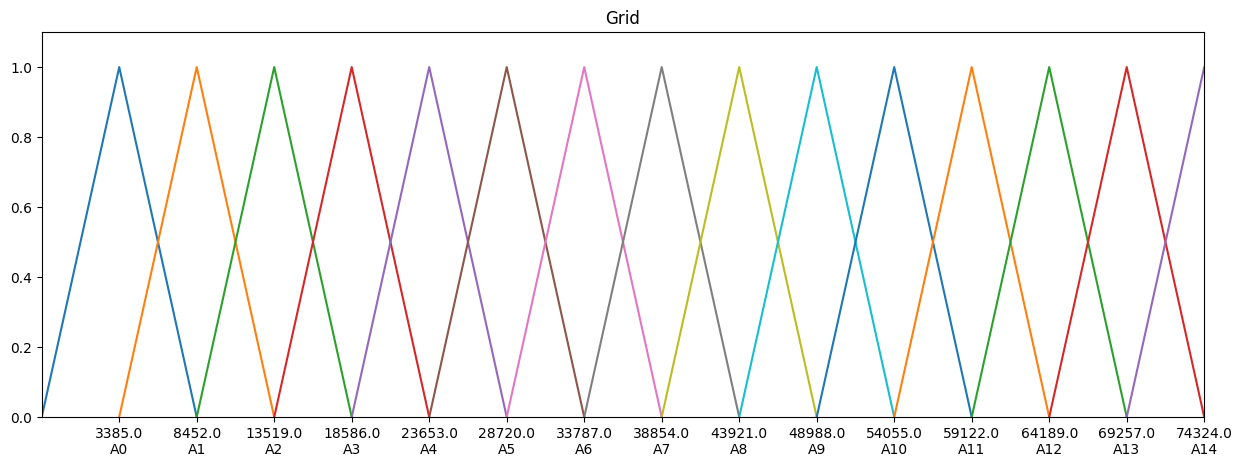

In [15]:
# 4. Xây dựng phân vùng mờ (Grid Partitioner)
partitioner = Grid.GridPartitioner(data=train_data, npart=15)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
partitioner.plot(ax)

In [16]:
# 5. Fuzzyfy dữ liệu huấn luyện (Chuyển đổi dữ liệu huấn luyện thành các giá trị mờ)
fuzzyfied = partitioner.fuzzyfy(train_data)

In [17]:
# 6. Tạo các mối quan hệ logic giữa các  mờ (FLR)
patterns = FLR.generate_non_recurrent_flrs(fuzzyfied)
print([str(k) for k in patterns])

['A0 -> A0', 'A0 -> A1', 'A1 -> A0', 'A1 -> A1', 'A0 -> A2', 'A1 -> A2', 'A2 -> A1', 'A2 -> A2', 'A2 -> A0', 'A1 -> A3', 'A2 -> A3', 'A3 -> A1', 'A3 -> A2', 'A3 -> A3', 'A2 -> A4', 'A3 -> A4', 'A4 -> A3', 'A4 -> A4', 'A4 -> A2', 'A3 -> A5', 'A4 -> A5', 'A5 -> A3', 'A5 -> A4', 'A5 -> A5', 'A4 -> A6', 'A5 -> A6', 'A6 -> A5', 'A6 -> A6', 'A5 -> A7', 'A6 -> A7', 'A7 -> A6', 'A7 -> A7', 'A6 -> A8', 'A7 -> A8', 'A8 -> A7', 'A8 -> A8', 'A8 -> A6', 'A7 -> A5', 'A7 -> A9', 'A8 -> A9', 'A9 -> A8', 'A9 -> A9', 'A8 -> A10', 'A9 -> A10', 'A10 -> A9', 'A10 -> A10', 'A9 -> A11', 'A10 -> A11', 'A11 -> A10', 'A11 -> A11', 'A10 -> A8', 'A11 -> A8', 'A11 -> A9', 'A10 -> A12', 'A11 -> A12', 'A12 -> A11', 'A12 -> A12', 'A12 -> A10', 'A9 -> A7', 'A11 -> A13', 'A12 -> A13', 'A13 -> A12', 'A13 -> A13', 'A13 -> A11', 'A6 -> A4']


In [18]:
# 7. Xây dựng mô hình FTS
model = chen.ConventionalFTS(partitioner=partitioner)
model.fit(train_data)
print(model)

Conventional FTS:
A0 -> A0,A1
A1 -> A0,A1,A2
A2 -> A1,A2,A3
A3 -> A2,A3,A4
A4 -> A3,A4,A5
A5 -> A4,A5,A6
A6 -> A5,A6,A7
A7 -> A6,A7,A8
A8 -> A7,A8,A9
A9 -> A10,A8,A9
A10 -> A10,A11,A9
A11 -> A10,A11,A12,A9
A12 -> A11,A12,A13
A13 -> A12,A13



In [19]:
# 8. Dự đoán dữ liệu test, val
y_pred_test = model.predict(test_data)
y_pred_val = model.predict(val_data)

In [20]:
# 9. Đánh giá độ chính xác thuật toán
test_mae = mean_absolute_error(y_pred_test, test_data)
test_mape = mean_absolute_percentage_error(y_pred_test, test_data)
test_rmse = np.sqrt(mean_squared_error(y_pred_test, test_data))
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

val_mae = mean_absolute_error(y_pred_val, val_data)
val_rmse = np.sqrt(mean_squared_error(y_pred_val, val_data))
val_mape = mean_absolute_percentage_error(y_pred_val, val_data)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Validation MAPE:', val_mape)

Testing MAE: 1385.0166373859213
Testing RMSE: 1547.1141207806434
Testing MAPE: 0.058161721135551986
Validation MAE: 1601.6699719871096
Validation RMSE: 1957.5398918142293
Validation MAPE: 0.031140446518665002


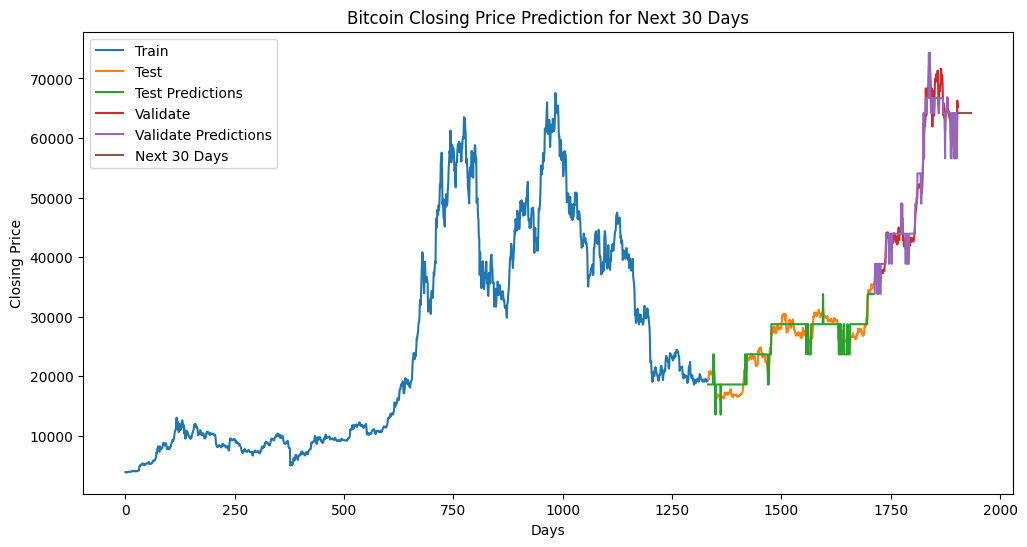

Predicted closing prices for the next 30 days:
[64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963]


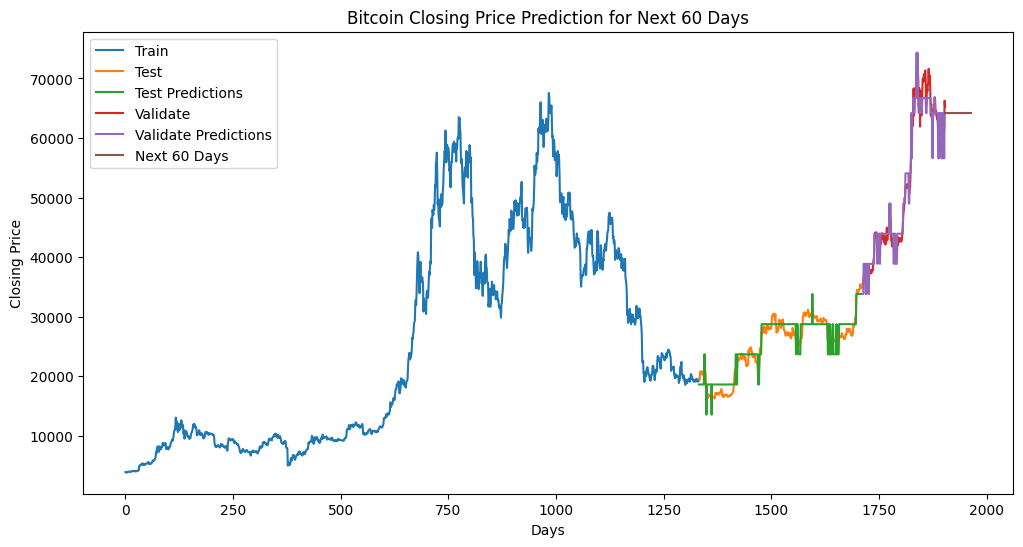

Predicted closing prices for the next 60 days:
[64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963]


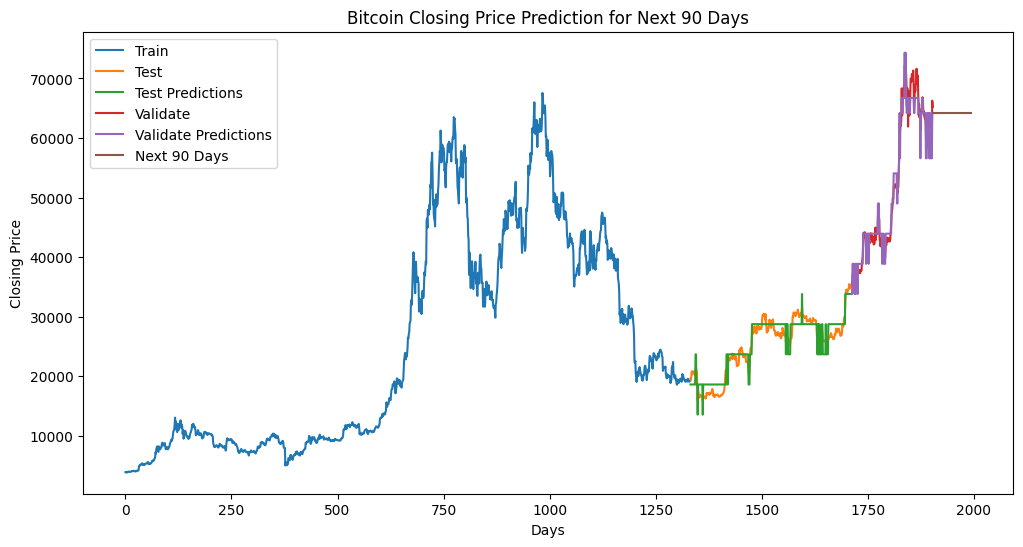

Predicted closing prices for the next 90 days:
[64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 6

In [21]:
# 10. Dự đoán 30, 60, 90 ngày tiếp theo
time_step = 100
def predict_future(model, data, days):
    temp_input = list(data)
    lst_output = []

    for _ in range(days):
        x_input = temp_input[-1]  # Lấy giá trị cuối cùng để dự đoán tiếp
        yhat = model.predict([x_input])[0]  # Dự đoán giá trị tiếp theo
        temp_input.append(yhat)
        lst_output.append(yhat)

    return np.array(lst_output)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, days)


    # Vẽ hình
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), train_data, label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test')
    plt.plot(range(len(train_data), len(train_data) + len(y_pred_test)), y_pred_test, label='Test Predictions')
    plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(val_data)), val_data, label='Validate')
    plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(y_pred_val)), y_pred_val, label='Validate Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'Bitcoin Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **Chia train test validate theo tỉ lệ 6:2:2**

In [22]:
# 2. Đọc file csv và lấy  giá Close
df = pd.read_csv('BTC.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df1 = df['Close'].values

In [23]:
# 3. Chia train test validate theo tỉ lệ 6:2:2
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

/usr/local/lib/python3.10/dist-packages/pyFTS/partitioners/partitioner.py:278: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


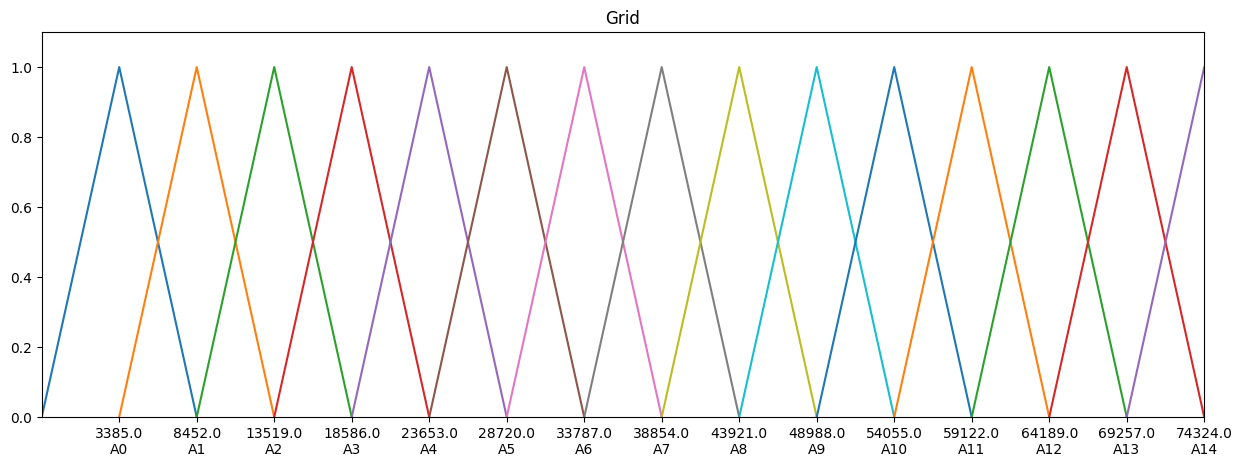

In [24]:
# 4. Xây dựng phân vùng mờ (Grid Partitioner)
partitioner = Grid.GridPartitioner(data=train_data, npart=15)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
partitioner.plot(ax)

In [25]:
# 5. Fuzzyfy dữ liệu huấn luyện (Chuyển đổi dữ liệu huấn luyện thành các giá trị mờ)
fuzzyfied = partitioner.fuzzyfy(train_data)

In [26]:
# 6. Tạo các mối quan hệ logic giữa các  mờ (FLR)
patterns = FLR.generate_non_recurrent_flrs(fuzzyfied)
print([str(k) for k in patterns])

['A0 -> A0', 'A0 -> A1', 'A1 -> A0', 'A1 -> A1', 'A0 -> A2', 'A1 -> A2', 'A2 -> A1', 'A2 -> A2', 'A2 -> A0', 'A1 -> A3', 'A2 -> A3', 'A3 -> A1', 'A3 -> A2', 'A3 -> A3', 'A2 -> A4', 'A3 -> A4', 'A4 -> A3', 'A4 -> A4', 'A4 -> A2', 'A3 -> A5', 'A4 -> A5', 'A5 -> A3', 'A5 -> A4', 'A5 -> A5', 'A4 -> A6', 'A5 -> A6', 'A6 -> A5', 'A6 -> A6', 'A5 -> A7', 'A6 -> A7', 'A7 -> A6', 'A7 -> A7', 'A6 -> A8', 'A7 -> A8', 'A8 -> A7', 'A8 -> A8', 'A8 -> A6', 'A7 -> A5', 'A7 -> A9', 'A8 -> A9', 'A9 -> A8', 'A9 -> A9', 'A8 -> A10', 'A9 -> A10', 'A10 -> A9', 'A10 -> A10', 'A9 -> A11', 'A10 -> A11', 'A11 -> A10', 'A11 -> A11', 'A10 -> A8', 'A11 -> A8', 'A11 -> A9', 'A10 -> A12', 'A11 -> A12', 'A12 -> A11', 'A12 -> A12', 'A12 -> A10', 'A9 -> A7', 'A11 -> A13', 'A12 -> A13', 'A13 -> A12', 'A13 -> A13', 'A13 -> A11']


In [27]:
# 7. Xây dựng mô hình FTS
model = chen.ConventionalFTS(partitioner=partitioner)
model.fit(train_data)
print(model)

Conventional FTS:
A0 -> A0,A1
A1 -> A0,A1,A2
A2 -> A1,A2,A3
A3 -> A2,A3,A4
A4 -> A4,A5
A5 -> A5,A6
A6 -> A5,A6,A7
A7 -> A6,A7,A8
A8 -> A7,A8,A9
A9 -> A10,A8,A9
A10 -> A10,A11,A9
A11 -> A10,A11,A12,A9
A12 -> A11,A12,A13
A13 -> A12,A13



In [28]:
# 8. Dự đoán dữ liệu test, val
y_pred_test = model.predict(test_data)
y_pred_val = model.predict(val_data)

In [29]:
# 9. Đánh giá độ chính xác thuật toán
test_mae = mean_absolute_error(y_pred_test, test_data)
test_mape = mean_absolute_percentage_error(y_pred_test, test_data)
test_rmse = np.sqrt(mean_squared_error(y_pred_test, test_data))
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

val_mae = mean_absolute_error(y_pred_val, val_data)
val_rmse = np.sqrt(mean_squared_error(y_pred_val, val_data))
val_mape = mean_absolute_percentage_error(y_pred_val, val_data)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Validation MAPE:', val_mape)

Testing MAE: 2153.301488886055
Testing RMSE: 2451.9395234100757
Testing MAPE: 0.08869536456510899
Validation MAE: 2002.58282735779
Validation RMSE: 2488.622564623583
Validation MAPE: 0.054021604773453635


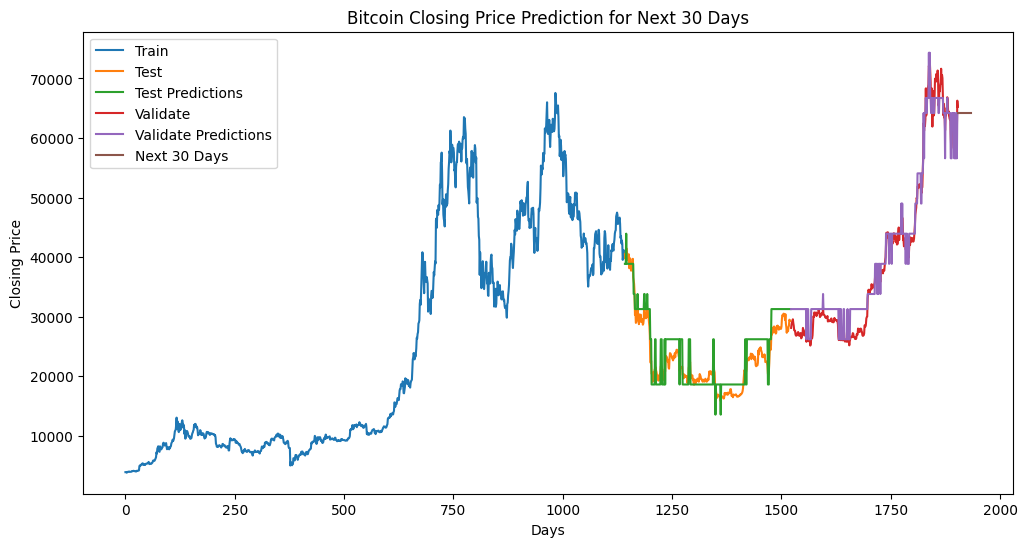

Predicted closing prices for the next 30 days:
[64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963]


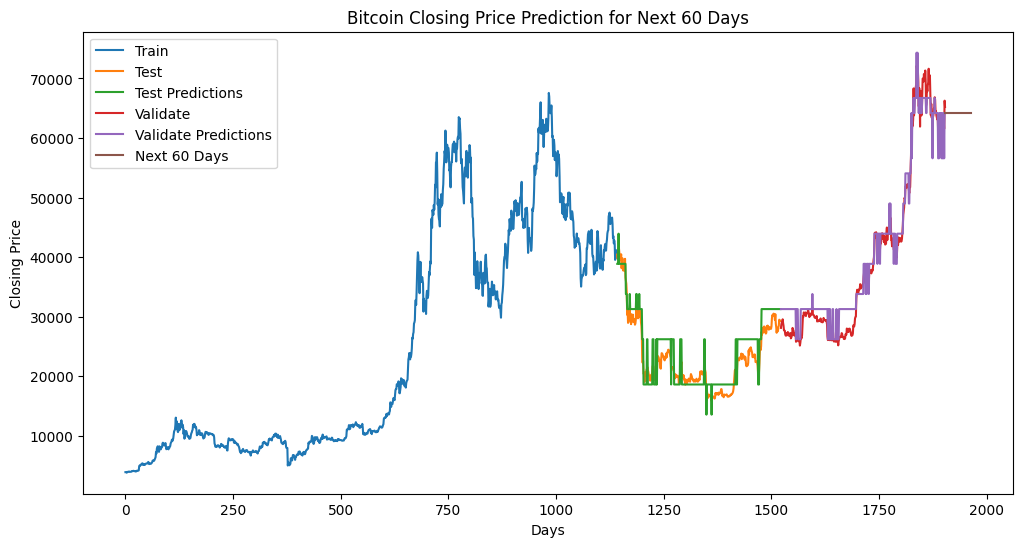

Predicted closing prices for the next 60 days:
[64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963]


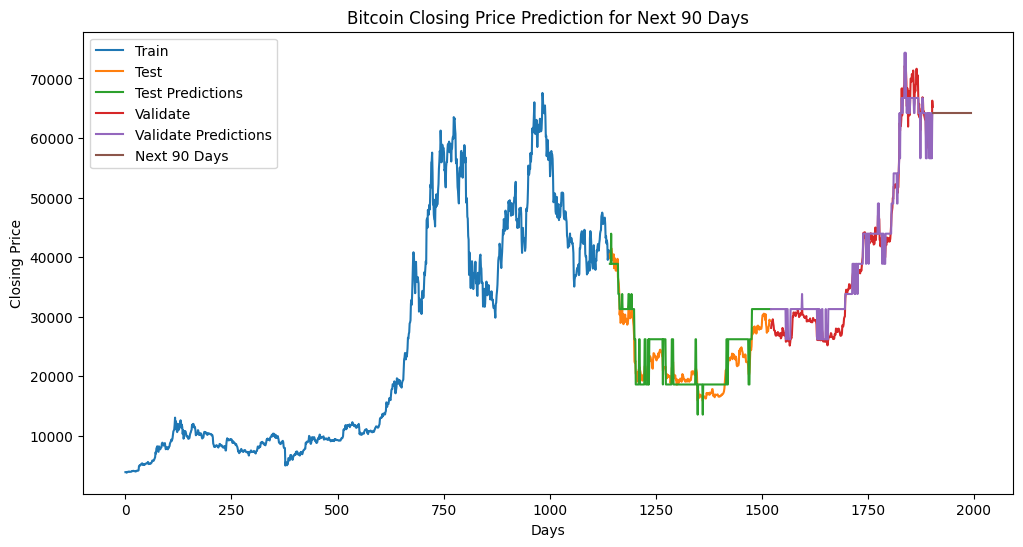

Predicted closing prices for the next 90 days:
[64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 64189.4952963 64189.4952963 64189.4952963
 64189.4952963 64189.4952963 6

In [30]:
# 10. Dự đoán 30, 60, 90 ngày tiếp theo
time_step = 100
def predict_future(model, data, days):
    temp_input = list(data)
    lst_output = []

    for _ in range(days):
        x_input = temp_input[-1]  # Lấy giá trị cuối cùng để dự đoán tiếp
        yhat = model.predict([x_input])[0]  # Dự đoán giá trị tiếp theo
        temp_input.append(yhat)
        lst_output.append(yhat)

    return np.array(lst_output)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, days)


    # Vẽ hình
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), train_data, label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test')
    plt.plot(range(len(train_data), len(train_data) + len(y_pred_test)), y_pred_test, label='Test Predictions')
    plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(val_data)), val_data, label='Validate')
    plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(y_pred_val)), y_pred_val, label='Validate Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'Bitcoin Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())